<h1 style="color:darkred; font-family:candara; font-size:400%; text-align:center;"> 
    Pneumonia detection with CNN
</h1>

***
<img src='https://storage.googleapis.com/kagglesdsdata/datasets%2F17810%2F23812%2Fchest_xray%2Ftest%2FNORMAL%2FIM-0001-0001.jpeg?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1593731637&Signature=BoOU9Uj6lrXHj0zHvrrsr3cN3g4FPnHwleJtHCLLjvei3Y9qYROLl812A4NIu1C9wkl87EQVdfvul6ZNEkVeELa7YlZPx0MTgA4LegRUUHnz2S%2Bh2ThBkR2cNuUGXB1L4TmHSD3PHbg0ANZlGEyhCsd%2BAFIKq9Zd7j9m0%2BjlSg3qUlpnEej21G4YEFxMMoj8eW4oRDp0zcNsqKLxLVi%2FlvgFhgYbrYHxvycwE6PU0DPY72j1Ne31jCod%2BpNKo0hC82%2Bmq2JaIuiE8L1lebfkDzx5f%2BojcxhGs1V7F6KZo3Q1yG0hfNSPKMz5oF%2FYR3nTWA9plpFV4dyOV%2BJ%2FK67hxQ%3D%3D' width='40%' align='right' ></img>



[**Pneumonia**](https://en.wikipedia.org/wiki/Pneumonia) is a lung infection that produces inflammation and that may appear either in one or both lungs. 
More specifically, the infection causes inflammation in the small air sacs in the lungs, otherwise known as [**alveoli**](https://en.wikipedia.org/wiki/Pulmonary_alveolus). 
There are several reasons for this disease to appear, for example bacteria, viruses, and funghi might lead to it. 

Alveoli filled with fluid or pus can make it really difficult to breathe. 
Typical symptoms include cough (either dry or productive), chest pain, fever and difficulty breathing. 
This is one of the most dangerous diseases among all age groups, resulting in **1.4 million deaths in 2010** (7% of the world's yearly total) and in 2016 it was the 4th leading cause of death in the world, resulting in **3.0 million deaths worldwide**. 
Pneumonia is considered to be the most deadly *communicable disease* as of 2016 and is most dangerous for children less than 5 and people over 75 years. 


In this project we will show how to create a neural network that predicts whether or not a patient has pneumonia only by looking at chest X-Rays of people with an accuracy of about **87%**.



The database we used to train this neural network can be found in [this Kaggle database](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). 


To begin with, let's do some imports of some of the packages we will be using:





In [78]:
# Most of the necessary packages
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns; sns.set();
import tensorflow as tf
import os, shutil, re
import zipfile # Manipulate zipfiles
import cv2 # Computer vision tasks such as reading image from file, changing color channels
from tqdm import tqdm # Wraps an iterator and shows the current stage percentage 

## Importing data

We first need to get access to the Kaggle database.




In [79]:
# Select and download database
os.environ['KAGGLE_USERNAME'] = "cuspime"
os.environ['KAGGLE_KEY']= "9ed0f248d333d5e7189ada238043f940"

# Command to use the desired database Use when running from google colab
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


We now have to unzip the downloaded database

In [80]:
path_to_zip = '/content/chest-xray-pneumonia.zip'
zipped = zipfile.ZipFile(path_to_zip, 'r')

!unzip \*.zip > /dev/null # To extract the zip file

replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Following the intuition from Time Series analysis, where we know we should actually try to forecast at most as much as the extension of the validaiton set. Since the validaiton set is so small (16), we increase the validaiton set by importing some of the images from the train set (and deleting them from the original folder).

In [81]:
# Importing images
from glob import glob # Great for getting the full paths to all images

# Paths to training and testing images folders
path='/content/chest_xray/'
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Create empty list
number_of_files_to_move = 116 # I chose 116 to leave exactly 5100 images on the training set. We all really like the decimal system after all
example=[]
# Make a loop that finds the full paths of the images as a list of strings
for i, subfolder_name in enumerate( os.listdir(train_dir) ):
    for extension in ['jpg','jpeg', 'png']:
      example.extend(glob(train_dir +'/'+subfolder_name+'/*.'+extension) )
      # print(example)
# Move 
for image_original_path in (example[-(number_of_files_to_move//2):] + example[:number_of_files_to_move//2]):
  shutil.move(image_original_path, re.sub('/train/', '/val/' ,image_original_path))

In [82]:
# We now define function that will match all the image types there might be and will give labels to each subfolder
def get_data(path_to_folder, types_list=['jpg','jpeg', 'png'] ):
  """ This function gives all the image types within the list 'types_list' and
  provides a label for each subfolder.
  path_to_folder (str): path to the main folder where images are located
  types_list (list): list of strings of the extensions we're interested in

  This function returns (x,y), where x is a numpy array with the path to every 
  image found and y is a list of labels.
  """
  Data = []
  labels = []
  for i, subfolder_name in enumerate( os.listdir(train_dir) ):
    for extension in types_list:
      Data.extend(glob(path_to_folder +'/'+subfolder_name+'/*.'+extension) )
      labels.append([i for j in glob(path_to_folder +'/'+subfolder_name+'/*.'+extension ) ] )
  labels = np.concatenate(labels).ravel().astype('int')
  # print(Data[-10:], labels[-10:]) # To check the labels we get correspond to the key we assign later on the dictionary
  return Data, labels  

# Get the paths to the images and and the labels
Data_train, y_train = get_data(train_dir)
# Data_val, y_val = get_data(val_dir)
Data_test, y_test = get_data(test_dir)

# We'll create a dictionary to remember what the different values of the labels mean
labels_name = {0:'NORMAL', 1:'PNEUMONIA'}

These labels correspond to 1 when the patient is *normal* and 0 when the patient has *pneumonia*, as is saved in the dictionary **labels_name**.

We now have our data and a list of the corresponding labels. In order to not bias our network to learn something from the long, ordered lists in which these are presented, we need to select a random permutation of said lists (making sure that both the data and the label move together).

In [83]:
from sklearn.utils import shuffle #to shuffle the data pairwise
# Data_train, y_train = shuffle(Data_train, y_train)
# Data_val, y_val = shuffle(Data_val, y_val)
Data_test, y_test = shuffle(Data_test, y_test)

## Data exploration

We start by checking if there is some bias:


In [85]:
print('''The data used for training is biased.\n 
It has {:.2f}% of people without Pneumonia'''.format(100*y_train.sum()/len(y_train) ) )

The data used for training is biased.
 
It has 74.84% of people without Pneumonia


Since there the data is not even we will have to "come up" with more data by making an augmentation of the training data.

We now check if our images are the same size:

In [86]:
from PIL import Image # Support for opening, manipulating, and saving many different image file formats

dim=[]
i=1
for images in Data_test:
    img = Image.open(images)
    size = img.size
    if size not in dim:
        dim.append(size)
        i+=1
#     if(i>5): # Break the loop after 5 different dimensions are recorded
#         break
print(dim[:5])

[(1040, 768), (792, 560), (1550, 1033), (1280, 1000), (1624, 1288)]


They are not and since the CNN in Tensorflow really really like it to always have the same image size, we will have to address this by resizing the images later.

Now, to have a better idea about what the images look like, we will make use of [cv2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html), which is a very nice python package that easily allows to read images from files.

The matrix representation of one of the images is (768, 1040, 3)


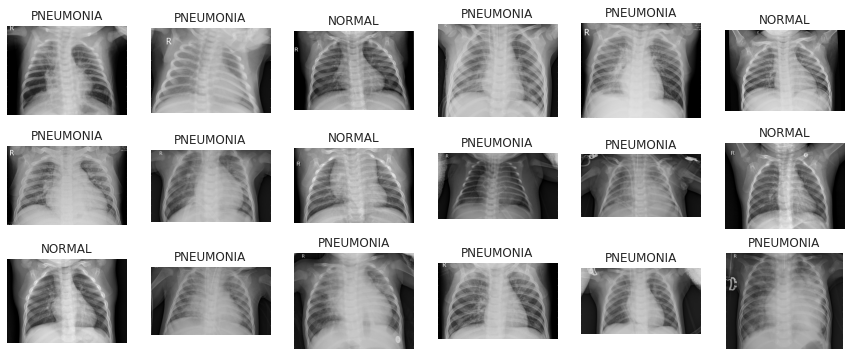

In [87]:
def view_image(image): # Function to view an image
    image_cv = cv2.imread(image) 
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)); 
    plt.axis('off');
# view_image(Data[50]); #view a single image

#To know the dimensions of one of these images as a matrix, use
print('The matrix representation of one of the images is '+ str( cv2.imread(Data_test[0]).shape) )

# Plot the first N images
n_rows = 3
n_cols = 6
N = n_rows*n_cols
plt.figure(figsize=(15,6))
for i, image in enumerate(Data_test[:N]):
  plt.subplot(n_rows, n_cols, i+1)
  view_image(image)
  plt.title(labels_name[y_test[i]] ) # This is when we use the labels_name 😎

From these images it seems like having the overall brightness of the X-Ray and some extended white regions tell us something important. Most likely it tells us that there's some sort of liquid in the lungs dispersing the light.

# Data preprocessing

As we mentioned before, we need to resize our images and make a numpy array from them, which we'll use for the CNN.
We will also make use of **data augmentation** by shearing, flipping, rotating and zooming into the images from the training set. 

Doing this would take us forever and it would be a major drawback if keras didn't have a super easy function called `ImageDataGenerator` which automatically does all this for us.

We will also transform the images we will use for testing our model (after all the training) into a numpy array in order to be able to predict and compare labels.

**NB:** on a previous version of this project, we munching  all the RAM memory from Google Colab. The best way to go overcome this problem is to create a generator that will feed the model in batches.



In [88]:
from keras.preprocessing.image import ImageDataGenerator

input_size = 128 # This will be the input size for the CNN
batch_size = 32

train_data_generator = ImageDataGenerator(rescale = 1./255., shear_range=.2, 
                                          zoom_range=.2, horizontal_flip=True,
                                          vertical_flip=True, rotation_range=50.0)
val_data_generator = ImageDataGenerator(rescale = 1./255.)

training_set = train_data_generator.flow_from_directory(train_dir, 
                                                        target_size=(input_size,input_size), batch_size=batch_size,
                                                        class_mode='binary', shuffle=True)
val_set = val_data_generator.flow_from_directory(val_dir, 
                                                        target_size=(input_size,input_size), batch_size=batch_size,
                                                        class_mode='binary', shuffle=True)

# Now, for the test set create an empty list and append a resized image, like it's done for the train and val sets
X_test= []
for img_path in tqdm(Data_test):
    image = cv2.imread(img_path)
    X_test.append(cv2.resize(image,(input_size, input_size)))
X_test = np.array(X_test)/255.


  0%|          | 0/624 [00:00<?, ?it/s]

Found 5100 images belonging to 2 classes.
Found 132 images belonging to 2 classes.


100%|██████████| 624/624 [00:08<00:00, 76.77it/s]


# Creating the CNN

We will work with a somewhat basic CNN model with 2 Convolutional layers and a Dense hidden layer.


In [89]:
%%time

model = tf.keras.models.Sequential([
  # 1st Conv
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(input_size,input_size, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  # 2nd Conv
  tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  # Flattening
  tf.keras.layers.Flatten(), # Step to go from convolution to regular dense NN
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1,  activation='sigmoid') #Sigmoid activation works better for binary labels
] )


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary() # Great way to know what we're doing

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 61, 61, 64)        2400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              


We now define some callbacks for the model to take action when necessary:
* **[ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)**: with this callback we can save the weights and parameters (*i.e.* the best tuning) that performed best.
* **[EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)**: this callback stops the trainig when we are no longer making progress with our models. This doesn't mean we have to stop it the first time we don't improve. As a matter of fact, this is regulated by the "patience".
* **[ReduceLROnPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)**: when a metric has stopped improving we may want to reduce the Learning Rate(LR).

In [90]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, 
                                                save_weights_only=True, mode='min',verbose=1 )
reduce_learn_rate =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                                        patience=3, verbose=0, mode='auto',
                                                        min_delta=0.1, cooldown=0, min_lr=0.001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.1, verbose=1, patience=5, 
                                              mode='min', restore_best_weights=True)
# List of callbacks
callbacks = [checkpoint, early_stop, reduce_learn_rate]

## Fitting and testing the model

We now train our model for some epochs and check that we are not overfitting it to the training set although since the validation set is so small, it is hard to take a comparison of them seriously.

In [91]:
%%time
#Fit the CNN
epochs = 15
history = model.fit_generator(training_set, epochs=epochs, validation_data=val_set,
                              callbacks=callbacks)

Epoch 1/15
160/160 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8663
Epoch 00001: val_loss improved from inf to 2.58721, saving model to best_weights.hdf5
160/160 [==============================] - 137s 859ms/step - loss: 0.3414 - accuracy: 0.8663 - val_loss: 2.5872 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
160/160 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.9131
Epoch 00002: val_loss improved from 2.58721 to 1.71770, saving model to best_weights.hdf5
160/160 [==============================] - 142s 889ms/step - loss: 0.2217 - accuracy: 0.9131 - val_loss: 1.7177 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
160/160 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9227
Epoch 00003: val_loss improved from 1.71770 to 0.28745, saving model to best_weights.hdf5
160/160 [==============================] - 138s 864ms/step - loss: 0.1924 - accuracy: 0.9227 - val_loss: 0.2875 - val_accuracy: 0.9091 - lr: 0.0010
Ep

## Evaluating the model


 Let's test the model now

The loss after 8 epochs is 0.1635


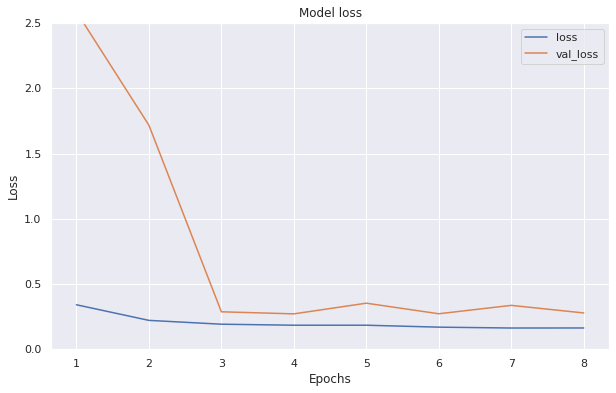

In [98]:
plt.figure(figsize=(10,6))
print("\n Let's test the model now\n")

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2.50])
plt.xticks(ticks=[i for i in range(len(history.history['loss']))], labels=[i+1 for i in range(len(history.history['loss']) )])
plt.title('Model loss')
plt.legend(loc='upper right');

print('''The loss after {} epochs is {:.4f}'''.format(len(history.history['loss']), history.history['loss'][-1]) )


 Let's test the model now

The accuracy of this model on the known training data 
after 8 epochs is 93.8039%


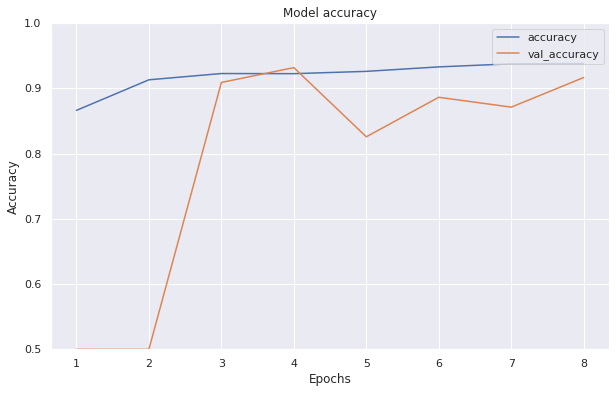

In [93]:
plt.figure(figsize=(10,6))
print("\n Let's test the model now\n")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.xticks(ticks=[i for i in range(len(history.history['accuracy']))], labels=[i+1 for i in range(len(history.history['accuracy']) )])
plt.title('Model accuracy')
plt.legend(loc='upper right');

print('''The accuracy of this model on the known training data 
after {} epochs is {:.4f}%'''.format(len(history.history['accuracy']), 100* history.history['accuracy'][-1]) )
# test_loss, test_acc = model.evaluate(X_val,  y_val, verbose=2);
# print('The accuracy reached by the model is: ' + str(test_acc))

## Model predictions 

We first make sure we are loading the *weights with which our model performed best*.

In [94]:
model.load_weights('best_weights.hdf5')

Now, with unseen images we predict what label they would have according to what our model has learned. 

In [95]:
predictions_prob = model.predict(X_test)
predictions = np.rint(predictions_prob).flatten()
accuracy = (predictions == y_test).sum()/len(y_test)
print('The accuracy of our model on the unseen test dataset is {:.4f}%'.format(100*accuracy) )

The accuracy of our model on the unseen test dataset is 88.9423%


As we can see, this model guessed right around **88.94%** of the times.




true_normal 189 
true_pneumonia 366 
false_normal 24 
false_pneumonia 45

The f1 score for this model is 0.9139


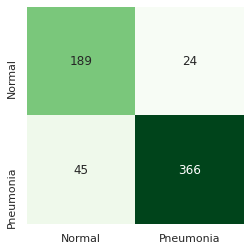

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test, predictions).T
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Greens", cbar=False, xticklabels=['Normal', 'Pneumonia'] , yticklabels=['Normal', 'Pneumonia'] );

true_normal = ((predictions==y_test) & (predictions==0)  ).sum()
true_pneumonia = ((predictions==y_test) & (predictions==1)  ).sum()
false_normal = ((predictions!=y_test) & (predictions==0)  ).sum()
false_pneumonia = ((predictions!=y_test) & (predictions==1)  ).sum()
print('true_normal', true_normal , '\ntrue_pneumonia',true_pneumonia , '\nfalse_normal',false_normal, '\nfalse_pneumonia',false_pneumonia)

precision = true_pneumonia / (true_pneumonia + false_pneumonia) # How accurate the model is to predict
recall = true_pneumonia / (true_pneumonia + false_normal)

f1_score = 2*precision*recall / (precision + recall)
print('\nThe f1 score for this model is {:.4f}'.format(f1_score))

# Summary


Adding more convolutional layers did not really improved the predictions so I just stayed with a simple model. However, this CNN created allows us to have really good predictions, specially for people with pneumonia, which to me is quite impressive given the simplicity of the CNN. 

* We have an [f1 score](https://en.wikipedia.org/wiki/F1_score) of The f1 score of **0.9139**, which is really really good.
* The accuracy of our model is **.889**, which is also pretty impressive


However, nothing is perfect and so, there are still some caveats of this model were
- The population we fed to this model wass not balanced and hence the model is biased towards predicting people with pneumonia (but this is not all bad because in medical settings it is better to give a false positive than to give a false negative). 
- To address the imbalance issue we have augmented the training data by transforming the given images which is both simple and powerful.
- The provided validation set was axtremely small to be of any use so we had to take some of the training images into the validation set.
- There is only one source of images. To increase the confidence in our model we should analyse several different resources.